In [125]:
# pip install boruta

# Filtro automatizado de SPAM en SMS

In [130]:
# Librerias

import numpy as np # tratamiento de arreglos
import pandas as pd # tratamiento y carga de dataframes

import matplotlib.pyplot as plt # Graficos y matriz de graficos
import seaborn as sns # Graficar las distribuciones

import nltk # Construir modelos con cadenas

from nltk import word_tokenize # tokenizacion 
from nltk import word_tokenize # obtiene las palabras mas populares
from nltk import FreqDist # diccionario de frecuencia de tokens
from nltk.stem import SnowballStemmer # encontrar raices de cadenas

from wordcloud import WordCloud # grafico de frecuencia de palabras

from sklearn.feature_extraction.text import TfidfVectorizer # vectorizacion de las cadenas

import warnings # para ignorar las advertencias innecesarias de pandas

from sklearn.model_selection import train_test_split # paraticion de la data

from imblearn.under_sampling import RandomUnderSampler # submuestreo
from imblearn.over_sampling import RandomOverSampler # sobremuestreo

from sklearn.metrics import roc_auc_score, roc_curve # curva de roc
from sklearn.metrics import classification_report, accuracy_score # matriz de confusion y AUC

# Metodos de Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import GridSearchCV # Ingresamos la grilla de parametros

from sklearn.ensemble import RandomForestClassifier # Random forest
from boruta import BorutaPy # importancia de variables

In [4]:
warnings.filterwarnings('ignore')

### Funciones

In [5]:
# Entregas una cadena y devuelve un arreglo de las principales palabras en minuscula
def tokenizar(texto):
    
    #tokenizamos el texto en minúsculas
    tokens = nltk.word_tokenize(texto.lower())

    #solo nos quedamos con los tokens que contengan letras 
    filtro_tokens = [token for token in tokens if token.isalpha()]        
    
    #eliminar stopwors
    filtro_tokens = [token for token in filtro_tokens if token not in stopwords]
    
    return filtro_tokens

# entregas los tokens y devuelde un arreglos de raices de los tokens
def stemming(lista_tokens):

    stems = [stemmer.stem(token) for token in lista_tokens]
    
    return stems

# combina las dos funciones anteriores
def tokenizar_y_stemming(texto):

    tokens = tokenizar(texto)
    tokens_stemmed = stemming(tokens)
    
    return tokens_stemmed

# Dibuja la curva ROC
def plot_roc_curve(y, y_proba, label = ''):
    '''
    dibujar la curva roc para las probabilidades y target entregados
    
    params:
    y: etiquetas originales
    y_proba: probabilidades resultado del modelo
    '''
    
    auc_roc = roc_auc_score(y, y_proba)
    fpr, tpr, thresholds = roc_curve(y, y_proba)
    
    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 12})
    plt.plot(fpr, fpr, c = 'red')
    plt.plot(fpr, tpr, label= (f"Curva ROC {label} (AUC = {auc_roc:.4f})"))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"Curva ROC {label}")
    plt.legend(loc=4, numpoints=1)

In [6]:
seed = 314159

### Cargamos la data

In [7]:
# Leemos los datos separados por tabulacion y almacenamos en dos columnas
messages = pd.read_csv('SMSSpamCollection.csv', sep='\t', names=["label", "message"])
messages.head(2)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


## Exploración

### Que tan largo son los mensaje?

In [8]:
messages['length'] = messages['message'].apply(lambda text: len(text))
messages.head(2)

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29


### Lonigitud de las cadenas

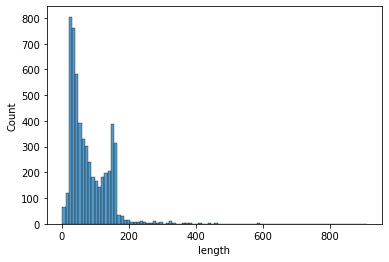

In [9]:
sns.histplot(data = messages, x = 'length')
pass

In [10]:
messages.describe()

,length
count,5572.000000
mean,80.489950
std,59.942907
min,2.000000
25%,36.000000
50%,62.000000
75%,122.000000
max,910.000000


### ¿Hay alguna diferencia entre las longitudes de mensajes *ham* y *spam*?

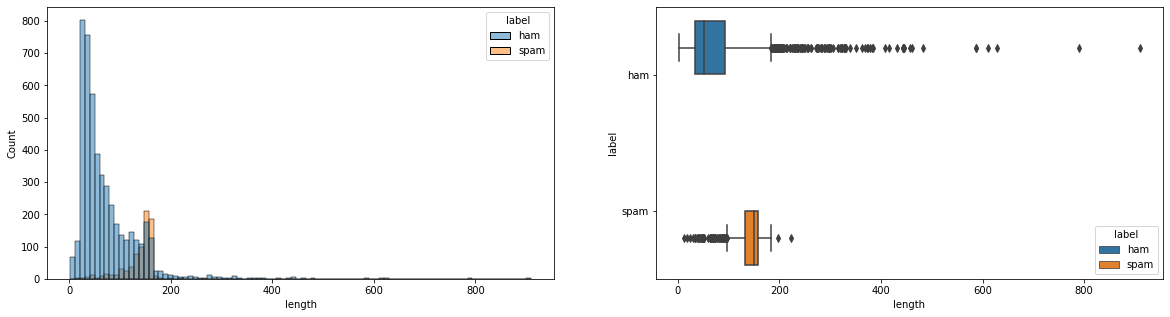

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5)) # figsize: largo x ancho
sns.histplot(data = messages, x = 'length', hue = 'label', ax=axs[0])
sns.boxplot(data = messages, x = 'length',  y = 'label', hue='label', ax=axs[1])
pass

graficamente se puede observar en el boxplot que la mediana de la longitud del mensaje de un spam es mayor a la de un ham.

la variable longitud presenta valores atipicos, pero este puede ser significativo para el modelo, dado que una extensa longitud pude dar indicios de que no es spam.

### juntamos la totalidad de mensajes

In [12]:
message_total = ' '.join(messages['message'])

In [13]:
# cantidad de caracteres
len(message_total)

454061

#### Es necesario para poder tokenizar

In [14]:
# nltk.download('punkt')

In [15]:
total_tokens = word_tokenize(message_total)

In [16]:
total_tokens[:5]

['Go', 'until', 'jurong', 'point', ',']

In [17]:
freq = FreqDist(total_tokens)

In [18]:
freq

FreqDist({'.': 4901, 'to': 2159, 'I': 1975, ',': 1938, 'you': 1893, '?': 1550, '!': 1397, 'a': 1339, 'the': 1211, '...': 1146, ...})

In [19]:
freq.most_common(5)

[('.', 4901), ('to', 2159), ('I', 1975), (',', 1938), ('you', 1893)]

In [20]:
print(f'Hay { len(freq.keys()) } tokens diferentes')

Hay 11526 tokens diferentes


## Preprocesamiento

### Preprocesamiento de textos

En esta sección se eliminan las palabras más comunes que no aportan mayor valor al texto de sinopsis de cada película. Para esto usamos la librería `nltk` y la funcion `stopwords`, y para encontrar palabras con la misma raiz, hacemos uso de la funcion `SnowballStemmer`, que realiza el stemming

In [21]:
# nltk.download('stopwords')

In [22]:
# elegimos el idioma ingles
stopwords = nltk.corpus.stopwords.words('english')

In [23]:
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [24]:
# elegimos el idioma ingles
stemmer = SnowballStemmer('english')

In [25]:
tokens = tokenizar_y_stemming(message_total)

In [26]:
FreqDist(tokens).most_common(5)

[('u', 1132), ('call', 658), ('go', 455), ('get', 447), ('ur', 391)]

In [27]:
message_preprocesada = ' '.join(tokens)
message_preprocesada[:500]

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat ok lar joke wif u oni free entri wkli comp win fa cup final tkts may text fa receiv entri question std txt rate c appli u dun say earli hor u c alreadi say nah think goe usf live around though freemsg hey darl week word back like fun still tb ok xxx std chgs send rcv even brother like speak treat like aid patent per request mell oru minnaminungint nurungu vettam set callertun caller press copi friend callertun winner va'

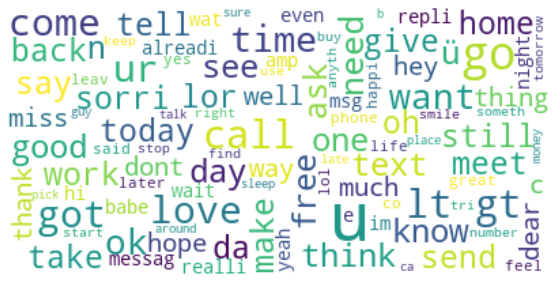

In [28]:
# maximo tamaño de fuente de una palabra, maxima cantidad de palabras y el fondo
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white")
wordcloud = wordcloud.generate(message_preprocesada)

plt.figure(figsize = (30,5)) # tamaño de figura
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") # quitamos los ejes
plt.show()

Parámetros:

`max_df`: máxima frecuencia utilizada. si el token aparece en más del 80% del documento probablemente no tenga mucho significado

`min_df`: cantidad mínima de documentos en los que debe aparecer el token para ser considerado. En este caso 0.2 es un porcentaje de documentos pero también se puede utilizar una cantidad absoluta (5, 10 documentos)

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.8, min_df = 0.01, use_idf=True, tokenizer=tokenizar_y_stemming)

tfidf_matrix = tfidf_vectorizer.fit_transform(messages['message'])

tfidf_matrix.shape

(5572, 154)

In [30]:
# cadenas seleccionadas
terms = tfidf_vectorizer.get_feature_names()

In [31]:
terms[:5]

['alreadi', 'also', 'alway', 'amp', 'anyth']

In [32]:
len(terms)

154

In [33]:
df_text = pd.DataFrame(tfidf_matrix.toarray(), columns = terms)
df_messages = pd.concat( [messages, df_text], axis=1)

del(df_text) # eliminamos el data frame con las frecuencias

In [34]:
df_messages.head(2)

,label,message,length,alreadi,also,alway,amp,anyth,around,ask,...,well,win,wish,word,work,would,yeah,year,yes,ü
0,ham,"Go until jurong point, crazy.. Available only ...",111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ham,Ok lar... Joking wif u oni...,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Antes de pasar al preprocesamiento del modelo, hacemos un peque analisis exploratorio a los SPAM

In [35]:
message_spam = messages[messages['label'] == 'spam']
message_total_spam = ' '.join(message_spam['message'])
tokens = tokenizar_y_stemming(message_total_spam)

# Las cadenas mas comunes son:
FreqDist(tokens).most_common(5)

[('call', 365), ('free', 219), ('txt', 156), ('ur', 144), ('u', 142)]

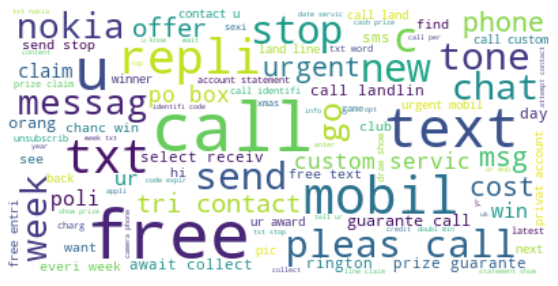

In [36]:
message_spam_preprocesada = ' '.join(tokens)

# maximo tamaño de fuente de una palabra, maxima cantidad de palabras y el fondo
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white")
wordcloud = wordcloud.generate(message_spam_preprocesada)

plt.figure(figsize = (30,5)) # tamaño de figura
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") # quitamos los ejes
plt.show()

Estas son las cadenas de palabras o raices que se suelen encontrar en un spam. Se espera que el modelo aprenda de ellas y que aparezcan un grupo representativo en el modelo, por ejemplo: `free`, `call`, `text`, `mobil`, `etc`.

### Preprocesamiento para el modelo

In [37]:
target = 'label'
message = 'message'

### convertimos el target a numérico con `map`

In [38]:
mapping_target = {'ham': 0, 'spam': 1}

In [39]:
df_messages[target] = df_messages[target].map(mapping_target)

In [40]:
df_messages.head(2)

,label,message,length,alreadi,also,alway,amp,anyth,around,ask,...,well,win,wish,word,work,would,yeah,year,yes,ü
0,0,"Go until jurong point, crazy.. Available only ...",111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Ok lar... Joking wif u oni...,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### porcentaje de unos en el target

In [41]:
df_messages[target].mean()

0.13406317300789664

In [42]:
df_messages[target].value_counts()

0    4825
1     747
Name: label, dtype: int64

## División en conjuntos de entrenamiento y validación

### división en features y target

In [43]:
X = df_messages.drop([target, message], axis = 1)
y = df_messages[target]

In [44]:
X.head(2)

,length,alreadi,also,alway,amp,anyth,around,ask,award,b,...,well,win,wish,word,work,would,yeah,year,yes,ü
0,111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
y.head(2)

0    0
1    0
Name: label, dtype: int64

In [46]:
X.shape

(5572, 155)

In [47]:
y.shape

(5572,)

In [48]:
y.mean()

0.13406317300789664

### división en train y test

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seed, stratify = y)

In [50]:
X_train.shape, X_test.shape

((4457, 155), (1115, 155))

In [51]:
y_train.shape, y_test.shape

((4457,), (1115,))

In [52]:
y_train.mean()

0.13417096701817366

In [53]:
y_test.mean()

0.1336322869955157

In [54]:
y_train.value_counts()

0    3859
1     598
Name: label, dtype: int64

In [55]:
y_test.value_counts()

0    966
1    149
Name: label, dtype: int64

### Se usaran modelos en los cuales `no es necesario el escalamiento`

## Balanceo de datos

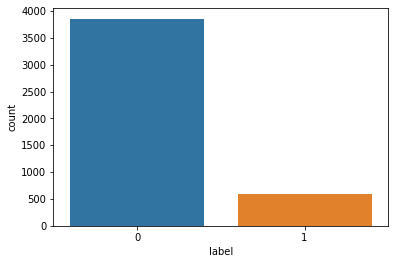

In [56]:
sns.countplot(x = y_train)
pass

In [57]:
rus = RandomUnderSampler(sampling_strategy = 0.8, random_state = seed)
ros = RandomOverSampler(sampling_strategy = 0.8, random_state = seed)

In [58]:
X_rus, y_rus = rus.fit_resample(X_train, y_train)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [59]:
y_rus.value_counts()

0    747
1    598
Name: label, dtype: int64

In [60]:
y_ros.value_counts()

0    3859
1    3087
Name: label, dtype: int64

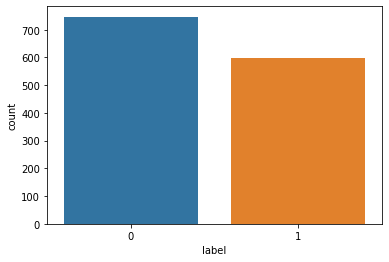

In [61]:
sns.countplot(x = y_rus)
pass

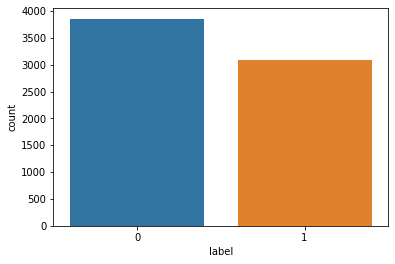

In [62]:
sns.countplot(x = y_ros)
pass

### Se evaluaran ambos criterios de balanceo de muestras al entrenar los modelos

## Entrenar el modelo

Los métodos de Naive Bayes suelen tener muy buena performance para este tipo de tareas dado que los vectores de features contienen frecuencias
- GaussianNB
- MultinomialNB 
- BernoulliNB

In [63]:
BernNB_rus = BernoulliNB(binarize = True)
BernNB_rus.fit(X_rus,y_rus)
print(BernNB_rus)

y_rus_train_pred = BernNB_rus.predict(X_rus)

BernoulliNB(binarize=True)


In [64]:
print(classification_report(y_rus, y_rus_train_pred))

              precision    recall  f1-score   support

           0       0.56      1.00      0.71       747
           1       0.00      0.00      0.00       598

    accuracy                           0.56      1345
   macro avg       0.28      0.50      0.36      1345
weighted avg       0.31      0.56      0.40      1345



In [65]:
BernNB_ros = BernoulliNB(binarize = True)
BernNB_ros.fit(X_ros,y_ros)
print(BernNB_ros)

y_ros_train_pred = BernNB_ros.predict(X_ros)

BernoulliNB(binarize=True)


In [66]:
print(classification_report(y_ros, y_ros_train_pred))

              precision    recall  f1-score   support

           0       0.56      1.00      0.71      3859
           1       0.00      0.00      0.00      3087

    accuracy                           0.56      6946
   macro avg       0.28      0.50      0.36      6946
weighted avg       0.31      0.56      0.40      6946



In [67]:
MultiNB_rus = MultinomialNB()
MultiNB_rus.fit(X_rus,y_rus)
print(MultiNB_rus)

y_rus_train_pred = MultiNB_rus.predict(X_rus)

MultinomialNB()


In [68]:
print(classification_report(y_rus, y_rus_train_pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91       747
           1       0.86      0.92      0.89       598

    accuracy                           0.90      1345
   macro avg       0.90      0.90      0.90      1345
weighted avg       0.90      0.90      0.90      1345



In [69]:
MultiNB_ros = MultinomialNB()
MultiNB_ros.fit(X_ros,y_ros)
print(MultiNB_ros)

y_ros_train_pred = MultiNB_ros.predict(X_ros)

MultinomialNB()


In [70]:
print(classification_report(y_ros, y_ros_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      3859
           1       0.87      0.91      0.89      3087

    accuracy                           0.90      6946
   macro avg       0.90      0.90      0.90      6946
weighted avg       0.90      0.90      0.90      6946



In [71]:
GausNB_rus = GaussianNB()
GausNB_rus.fit(X_rus,y_rus)
print(GausNB_rus)

y_rus_train_pred = GausNB_rus.predict(X_rus)

GaussianNB()


In [72]:
print(classification_report(y_rus, y_rus_train_pred))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82       747
           1       0.73      0.97      0.83       598

    accuracy                           0.83      1345
   macro avg       0.85      0.84      0.83      1345
weighted avg       0.86      0.83      0.83      1345



In [73]:
GausNB_ros = GaussianNB()
GausNB_ros.fit(X_ros,y_ros)
print(GausNB_ros)

y_ros_train_pred = GausNB_ros.predict(X_ros)

GaussianNB()


In [74]:
print(classification_report(y_ros, y_ros_train_pred))

              precision    recall  f1-score   support

           0       0.97      0.72      0.82      3859
           1       0.73      0.97      0.83      3087

    accuracy                           0.83      6946
   macro avg       0.85      0.84      0.83      6946
weighted avg       0.86      0.83      0.83      6946



In [75]:
y_rus_train_pred_proba = MultiNB_rus.predict_proba(X_rus)
y_ros_train_pred_proba = MultiNB_ros.predict_proba(X_ros)

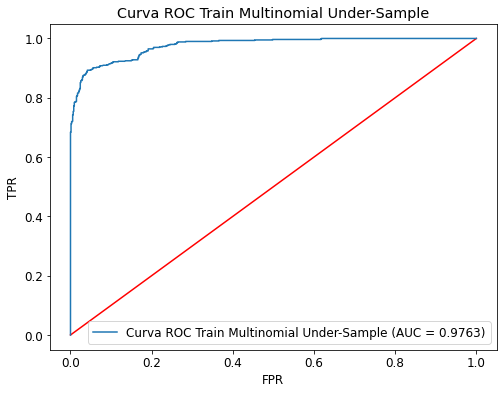

In [76]:
plot_roc_curve(y_rus, y_rus_train_pred_proba[:, 1], label = 'Train Multinomial Under-Sample')

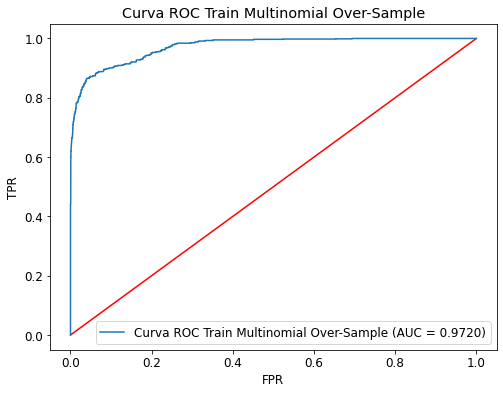

In [77]:
plot_roc_curve(y_ros, y_ros_train_pred_proba[:, 1], label = 'Train Multinomial Over-Sample')

### Encontrar los mejores hiperparámetros con Grid Search

In [78]:
params = {
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
            'binarize': [0.01, 0.05, 0.1, 0.5, 1],
         }

In [79]:
gs = GridSearchCV(estimator=BernoulliNB(), param_grid=params, scoring='roc_auc')

In [80]:
gs.fit(X_rus,y_rus)
print(gs.best_estimator_)
print(gs.best_params_)
print(f'El mejor AUC es {gs.best_score_}')

BernoulliNB(binarize=0.1)
{'alpha': 1.0, 'binarize': 0.1}
El mejor AUC es 0.9643015434361664


In [81]:
gs.fit(X_ros,y_ros)
print(gs.best_estimator_)
print(gs.best_params_)
print(f'El mejor AUC es {gs.best_score_}')

BernoulliNB(alpha=0.01, binarize=0.1)
{'alpha': 0.01, 'binarize': 0.1}
El mejor AUC es 0.9718746452689132


In [82]:
params = {
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
         }

In [83]:
gs = GridSearchCV(estimator=MultinomialNB(), param_grid=params, scoring='roc_auc')

In [84]:
gs.fit(X_rus,y_rus)
print(gs.best_estimator_)
print(gs.best_params_)
print(f'El mejor AUC es {gs.best_score_}')

MultinomialNB()
{'alpha': 1.0}
El mejor AUC es 0.9686746282405579


In [85]:
gs.fit(X_ros,y_ros)
print(gs.best_estimator_)
print(gs.best_params_)
print(f'El mejor AUC es {gs.best_score_}')

MultinomialNB(alpha=10.0)
{'alpha': 10.0}
El mejor AUC es 0.9740875347567567


### Se elige el modelo multinomial de Naive Bayes sin los hipermarametros optimos y aplicado a la base con oversample porque al parecer el modelo no mejora.

## Evaluación de resultados

### usamos el mejor modelo para evaluar el test

In [86]:
y_test_pred_proba = MultiNB_ros.predict_proba(X_test)[:,1]

In [87]:
roc_auc_score(y_test, y_test_pred_proba)

0.9735607986994039

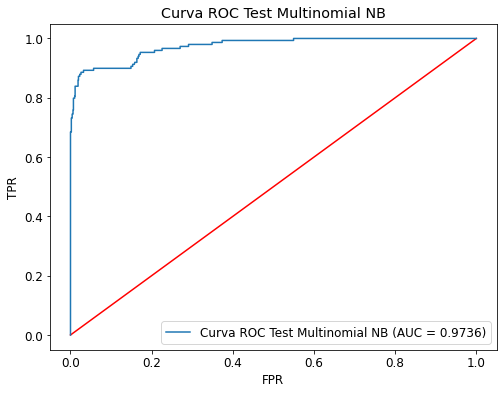

In [89]:
plot_roc_curve(y_test, y_test_pred_proba, 'Test Multinomial NB')

In [120]:
# data final
df_pred = pd.DataFrame(y_test_pred_proba, columns = {'y_predic'}, index = X_test.index.values)
data_test_final = pd.concat([X_test, y_test, df_pred], axis=1)
del(df_pred) # elimiinamos el dataframe temporal

In [121]:
data_test_final.head(2)

,length,alreadi,also,alway,amp,anyth,around,ask,award,b,...,wish,word,work,would,yeah,year,yes,ü,label,y_predic
4493,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.493123
107,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.861532


### Importancia de variables

In [129]:
# Aplicamos previamente un Random forest

In [136]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [5, 10],
          'min_samples_split': [10, 25, 50],
          'n_estimators': [25, 50, 100],
          'random_state': [seed]}

rf = RandomForestClassifier()
gs = GridSearchCV(estimator = rf, param_grid = params, scoring = 'roc_auc')
gs.fit(X_ros, y_ros)
best_rf = gs.best_estimator_
print(gs.best_estimator_)
print(gs.best_params_)
print(gs.best_score_)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=10,
                       random_state=314159)
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 314159}
0.9783020877264376


In [139]:
boruta = BorutaPy(estimator = best_rf, n_estimators = 'auto', max_iter = 100)
boruta.fit(X_ros.values, y_ros.values)

BorutaPy(estimator=RandomForestClassifier(criterion='entropy', max_depth=10,
                                          min_samples_split=10, n_estimators=96,
                                          random_state=RandomState(MT19937) at 0xE405CD8),
         n_estimators='auto', random_state=RandomState(MT19937) at 0xE405CD8)

In [140]:
green_area = X_ros.columns[boruta.support_].to_list()
blue_area = X_ros.columns[boruta.support_weak_].to_list()

In [141]:
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: ['length', 'award', 'c', 'call', 'cash', 'claim', 'collect', 'come', 'contact', 'custom', 'da', 'everi', 'free', 'get', 'go', 'got', 'gt', 'home', 'later', 'lor', 'love', 'lt', 'min', 'mobil', 'new', 'ok', 'per', 'phone', 'pleas', 'prize', 'repli', 'say', 'send', 'servic', 'show', 'sorri', 'stop', 'text', 'time', 'txt', 'u', 'ur', 'urgent', 'week', 'win', 'ü']
features in the blue area: ['messag']


In [144]:
green_area[1:6]

['award', 'c', 'call', 'cash', 'claim']

### Observamos que las varibles que se consideran mas predictivas o palabras que medicen mejor al spam son (dejando de lado a la longitud porque esta no es una palabra) serian: `award`, `c`, `call`, `cash`, `claim`,`etc`.

### Donde call ya habia sido identificada en el analisis exploratorio.

## `CONCLUSIONES`
## Entonces ya se cuenta con un modelo multinomial bayesiano que predice con un AUC de `0.9736` en nueva informacion (asi como el test) y se cuenta con rangos de pd en la columna y_predic de la tabla data_test_final. Ademas, con el analisis exploratorio, y un modelo sencillo de random forest como ayuda para el desarrollo del boruta, se ha podido identificar algunas palabras clave a la hora de identificar SPAM, por ejemplo: `call`. Estas palabras seran tomadas en cuenta en posteriores calibraciones.